In [1]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel
from typing_extensions import Annotated,List,Literal
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
import os
from dotenv import load_dotenv
load_dotenv()
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder



In [73]:
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model='gemma2-9b-it')

In [74]:
class stategraph(TypedDict):
    messages: Annotated[List[str],add_messages]
    next_agent:str = ""
    analyzed_text:str = ""
    written_text:str = ""
    analysis_done:str = ""
    written_done: str = ""

In [75]:
def command_center(state:stategraph):
    recent_message=state['messages'][-1].content
    if len(state['analysis_done'])==0:
        return {"next_agent":"analysis_agent"}
    elif len(state['written_done'])==0:
        return {"next_agent":"writing_center"}
    else:
        return {"next_agent":"DONE"}

In [76]:
def analysis_center(state:stategraph):
    recent_message=state['messages'][-1].content
    prompt=ChatPromptTemplate.from_messages([
        ("system","You are a helpful assistant"),
        ("human","Analyze the given {task}")
    ])
    chain=(prompt|llm)
    response=chain.invoke({"task":recent_message})
    return {"analyzed_text":response.content,"analysis_done":"done","next_agent":"command_center"}
                                            
                                            
                                            
                                            

In [77]:
def writing_center(state:stategraph):
    content_to_write=state['analyzed_text']
    prompt=ChatPromptTemplate.from_messages([
        ("system","You are a helpful assistant, write a 10 line summary"),
        ("human","Write 10 line summary of {content}")
    ])
    chain=prompt|llm
    response=chain.invoke({"content":content_to_write})
    return {"written_text":response.content,"written_done":"done","next_agent":"command_center"}

In [78]:
def router(state:stategraph):
    if state['next_agent']=='analysis_agent':
        return 'analysis_agent'
    elif state['next_agent']=='writing_center':
        return 'writing_agent'
    elif state['next_agent']=='DONE':
        return 'DONE'
    else:
        return 'command_center'

In [79]:
graph_state=StateGraph(stategraph)

In [80]:
graph_state.add_node("command_center",command_center)
graph_state.add_node("analysis_center",analysis_center)
graph_state.add_node("writing_center",writing_center)
graph_state.add_edge(START,"command_center")
graph_state.add_edge("analysis_center", "command_center")
graph_state.add_edge("writing_center", "command_center")
graph_state.add_conditional_edges( "command_center",router,
    {
"analysis_agent":"analysis_center",
"command_center":"command_center",
"writing_agent":"writing_center",
"DONE":END

    }
)


In [81]:
graph=graph_state.compile()

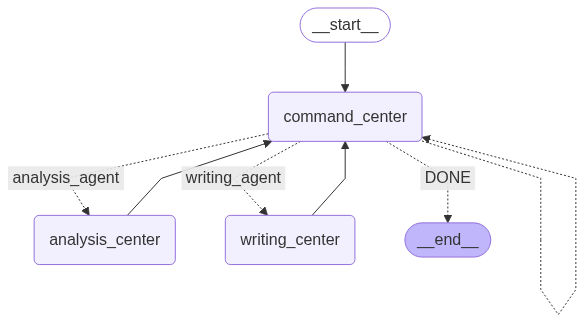

In [82]:
graph

In [83]:
graph.invoke({"messages":"Benefits of agentic AI in data engineering","analysis_done":"",
"next_agent": "",
"analyzed_text": "",
"written_text":"",
"written_done":""
})

{'messages': [HumanMessage(content='Benefits of agentic AI in data engineering', additional_kwargs={}, response_metadata={}, id='eb893e71-1078-4207-a0d0-46b3955e59b8')],
 'next_agent': 'DONE',
 'analyzed_text': "Let's break down the benefits of agentic AI in data engineering. \n\n**Agentic AI: A Primer**\n\nAgentic AI refers to artificial intelligence systems that can act autonomously and make decisions within a defined scope.  They possess the ability to:\n\n* **Observe:** Gather and interpret data from their environment.\n* **Reason:** Analyze the collected data and draw conclusions.\n* **Act:** Execute tasks and make decisions based on their reasoning.\n\n**Benefits in Data Engineering**\n\nHere's how agentic AI can revolutionize data engineering:\n\n1. **Automation of Repetitive Tasks:**\n\n   * Data pipelines often involve mundane, repetitive tasks like data ingestion, cleaning, and transformation. \n   * Agentic AI can automate these, freeing up data engineers to focus on more st